In [8]:
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import concat
from numpy import concatenate
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import KDTree
import miceforest as mf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [9]:
# read year 2020 data and turn the data types to float 16
df = pd.read_csv('EndUserData2020P2.csv', encoding = 'ISO-8859-1', skiprows = [0,2])
p1_2020 = df[['NB2_S_1_NYZ_sys_x_PcwOut_x', 'NB2_S_1_NYZ_sys_x_PcwIn_x', 'NB2_S_1_NYZ_cwp_9_HzSPR_x', 'NB2_S_1_NYZ_cwp_10_HzSPR_x', 'NB2_S_1_NYZ_cwp_11_HzSPR_x', 'NB2_S_1_NYZ_cwp_12_HzSPR_x', 'NB2_S_x_NYZ_x_x_Fcw_x']].copy()
p1_2020_nonzero = p1_2020.loc[p1_2020['NB2_S_x_NYZ_x_x_Fcw_x']>500]
p1_2020_state = pd.read_csv('EndUserData2020P2CWPState.csv', encoding = 'ISO-8859-1', skiprows = [0,2])
p1_2020_state_nonzero = p1_2020_state.loc[p1_2020['NB2_S_x_NYZ_x_x_Fcw_x']>500]
p1_2020_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_9_State_x']
p1_2020_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_10_State_x']
p1_2020_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_11_State_x']
p1_2020_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_12_State_x']    
p1_2020_nonzero['p_diff'] =  p1_2020_nonzero['NB2_S_1_NYZ_sys_x_PcwOut_x'] - p1_2020_nonzero['NB2_S_1_NYZ_sys_x_PcwIn_x']


In [10]:
# same procedure apply to 2021 data
df2 = pd.read_csv('EndUserData2021P2_fix.csv', encoding = 'ISO-8859-1', skiprows = [0,2])
p1_2021 = df2[['NB2_S_1_NYZ_sys_x_PcwOut_x', 'NB2_S_1_NYZ_sys_x_PcwIn_x', 'NB2_S_1_NYZ_cwp_9_HzSPR_x', 'NB2_S_1_NYZ_cwp_10_HzSPR_x', 'NB2_S_1_NYZ_cwp_11_HzSPR_x', 'NB2_S_1_NYZ_cwp_12_HzSPR_x', 'NB2_S_x_NYZ_x_x_Fcw_x']].copy()
p1_2021_nonzero = p1_2021.loc[p1_2021['NB2_S_x_NYZ_x_x_Fcw_x']>500]
p1_2021_state = pd.read_csv('EndUserData2020P2CWPState.csv', encoding = 'ISO-8859-1', skiprows = [0,2])
p1_2021_state_nonzero = p1_2020_state.loc[p1_2020['NB2_S_x_NYZ_x_x_Fcw_x']>500]
p1_2021_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x']\
                                          * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_9_State_x']
p1_2021_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x']\
                                          * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_10_State_x']
p1_2021_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x']\
                                          * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_11_State_x']
p1_2021_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x']\
                                          * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_12_State_x']    
p1_2021_nonzero['p_diff'] =  p1_2021_nonzero['NB2_S_1_NYZ_sys_x_PcwOut_x'] - p1_2021_nonzero['NB2_S_1_NYZ_sys_x_PcwIn_x']


In [11]:
p1_2021_nonzero.isnull().sum()

NB2_S_1_NYZ_sys_x_PcwOut_x    16258
NB2_S_1_NYZ_sys_x_PcwIn_x     16258
NB2_S_1_NYZ_cwp_9_HzSPR_x      3049
NB2_S_1_NYZ_cwp_10_HzSPR_x     3049
NB2_S_1_NYZ_cwp_11_HzSPR_x     3049
NB2_S_1_NYZ_cwp_12_HzSPR_x     3049
NB2_S_x_NYZ_x_x_Fcw_x             0
p_diff                        16258
dtype: int64

In [12]:
p1_2021_nonzero = mf.ampute_data(p1_2021_nonzero,perc=0.25,random_state=1991)
# Create kernel. 
kernel = mf.ImputationKernel(
  p1_2021_nonzero,
  datasets=4,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(2)

# Printing the kernel will show you some high level information.
print(kernel)

              Class: ImputationKernel
           Datasets: 4
         Iterations: 2
  Imputed Variables: 8
save_all_iterations: True


In [13]:
p1_2021_nonnull = kernel.complete_data(dataset=0, inplace=False)
print(p1_2021_nonnull.isnull().sum(0))

NB2_S_1_NYZ_sys_x_PcwOut_x    0
NB2_S_1_NYZ_sys_x_PcwIn_x     0
NB2_S_1_NYZ_cwp_9_HzSPR_x     0
NB2_S_1_NYZ_cwp_10_HzSPR_x    0
NB2_S_1_NYZ_cwp_11_HzSPR_x    0
NB2_S_1_NYZ_cwp_12_HzSPR_x    0
NB2_S_x_NYZ_x_x_Fcw_x         0
p_diff                        0
dtype: int64


In [14]:
p1_2021_nonnull.shape

(61073, 8)

<IPython.core.display.Javascript object>


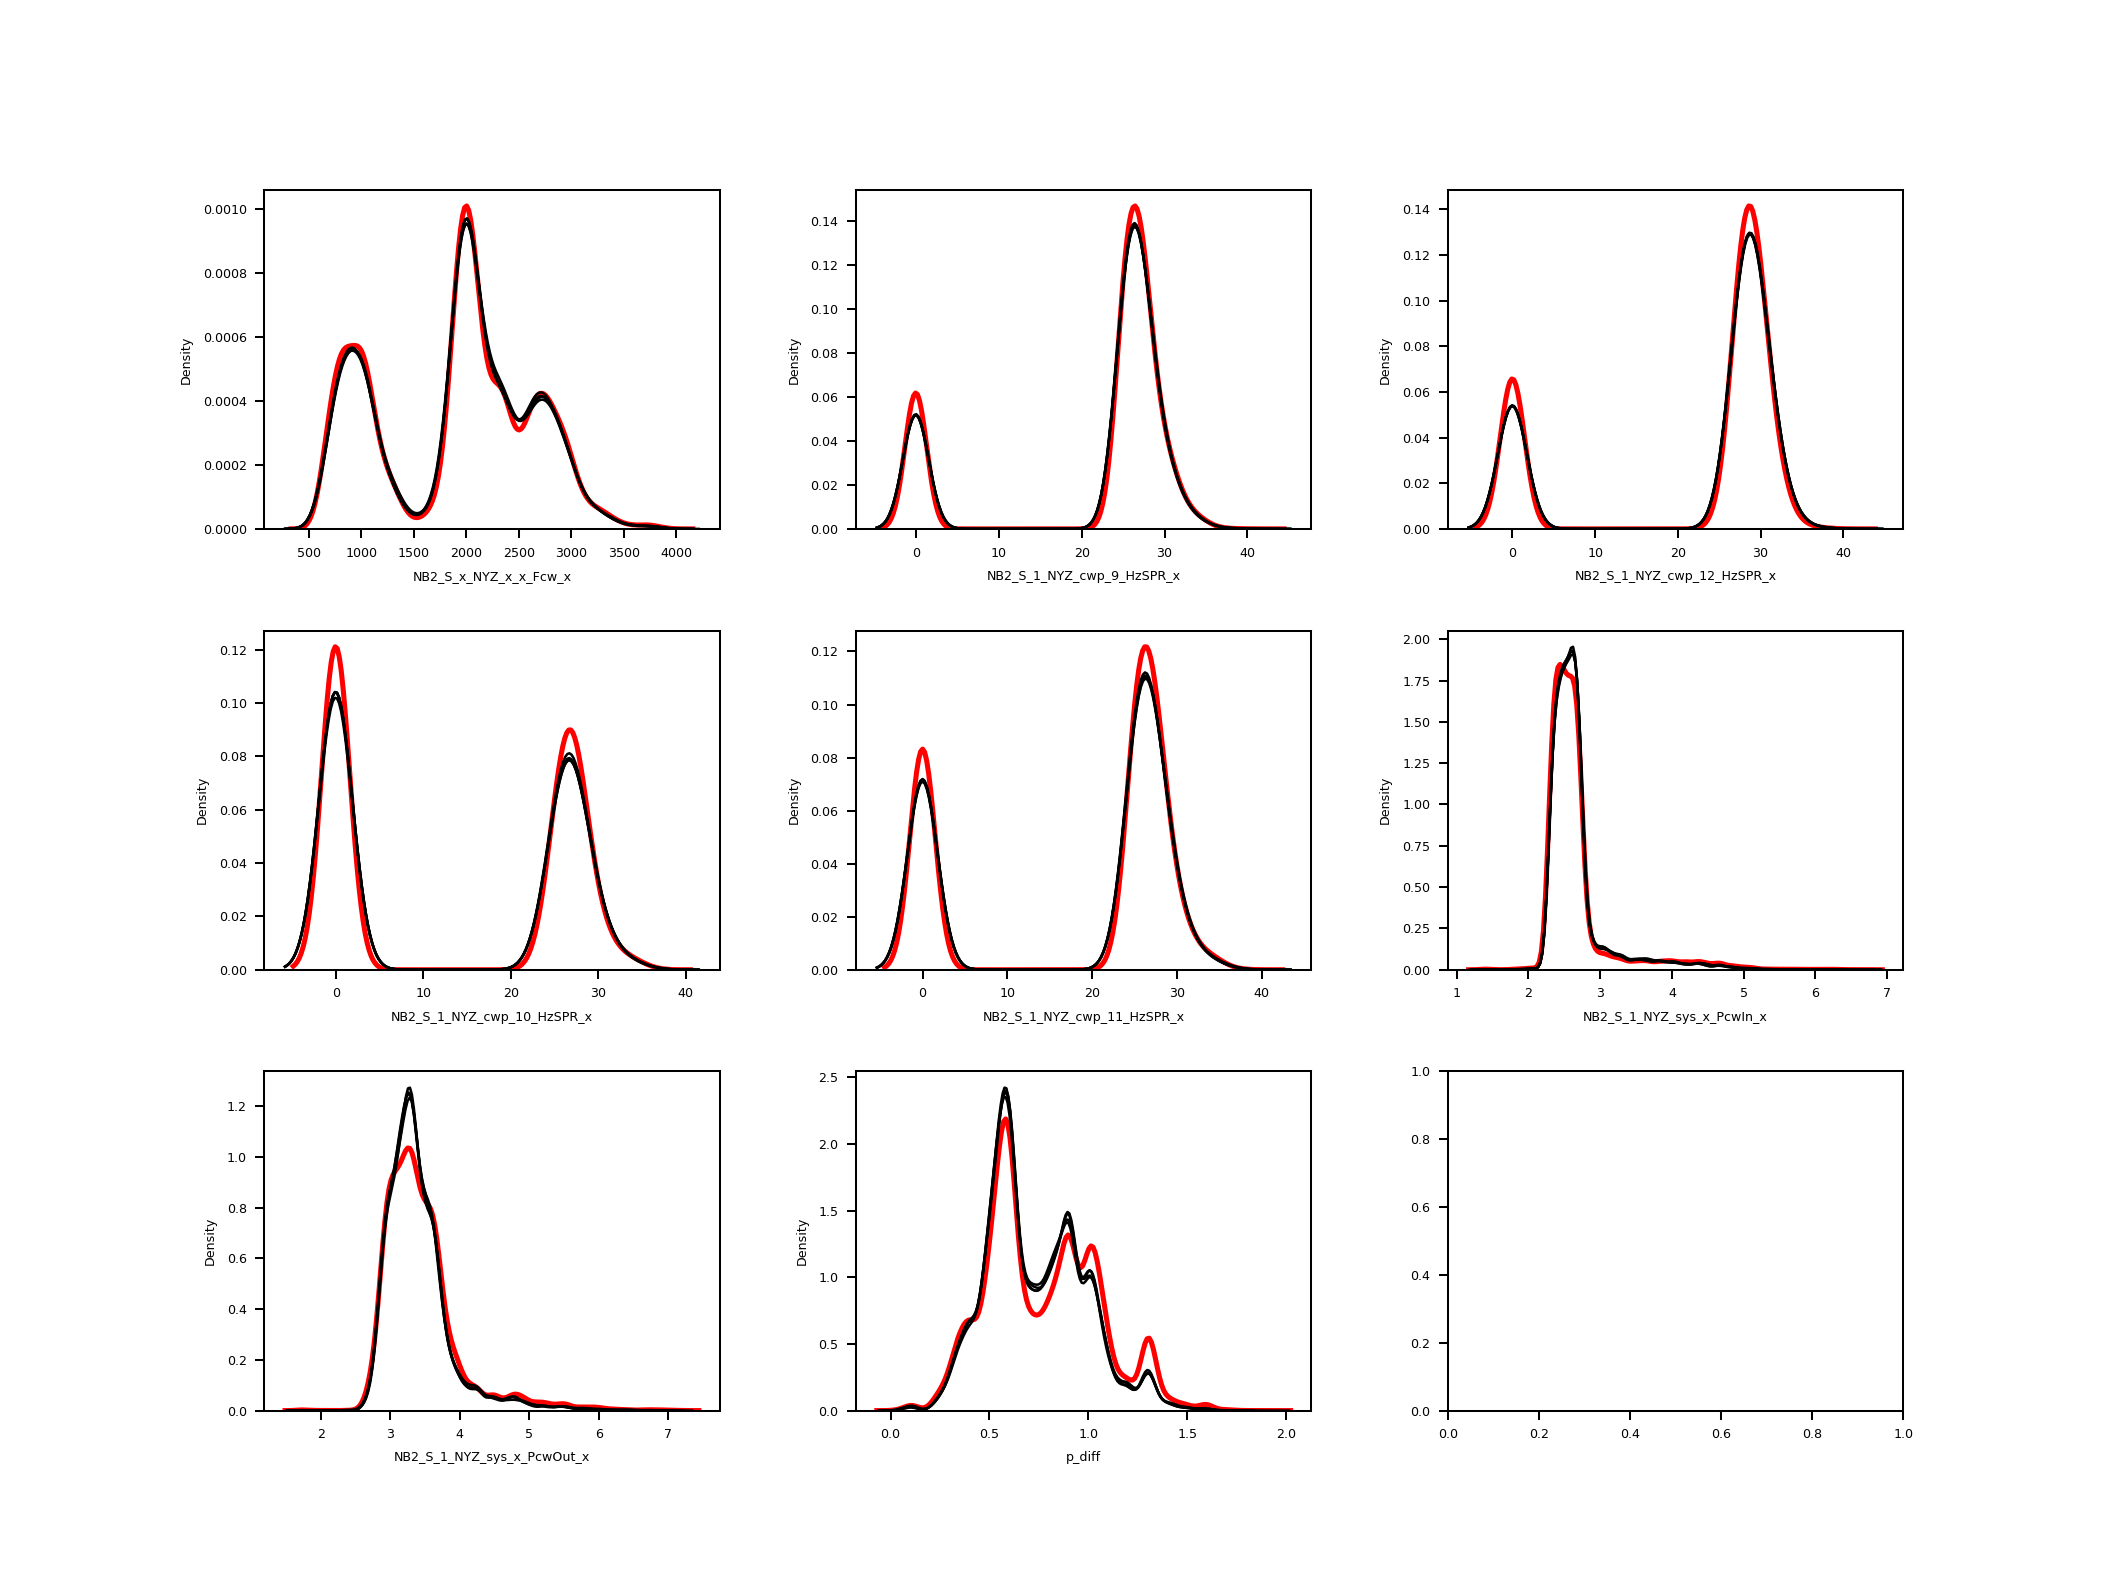

In [15]:
plt.rcParams.update({'font.size':5})
kernel.plot_imputed_distributions(wspace=0.3,hspace=0.3)
pyplot.show()
#The red line is the original data, and each black line are the imputed values of each dataset.

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		model.reset_states()
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
		model.reset_states()
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# run diagnostic experiments
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# config
	repeats = 10
	n_batch = 4
	n_epochs = 500
	n_neurons = 1
	# run diagnostic tests
	for i in range(repeats):
		history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.savefig('epochs_diagnostic.png')

# entry point
run()